### TODO:
Girish
- ~~Dataset construction~~

Mike
- ~~implement build_sequences & build_skipgrams~~
- ~~softmax word embeddings~~
- ~~implement to_onehot_tensor~~
- ~~seq2seq autoencoder~~

Guowei
- clustering & metrics
- low dimensional PCA / MDN / TSNE visualizations

In [1]:
# ensure everything is where it should be
!ls /data

df_features_final.tsv  modeling_data.tsv


In [4]:
# check gpus
!nvidia-smi

Sun Dec 10 21:13:58 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.98                 Driver Version: 384.98                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   36C    P8    32W / 149W |     11MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import collections
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
%matplotlib inline
plt.style.use('ggplot')

In [6]:
chunks = pd.read_table('/data/df_features_final.tsv', sep='|', chunksize=1000)
%time data = pd.concat(chunk for chunk in chunks)

subj = 'df_features_final.subject_id'
hadm = 'df_features_final.hadm_id'
service = 'df_features_final.service'
exp = 'df_features_final.expire_flag'
seq_cnt = 'df_features_final.icd_seq_cnt'
seq = 'df_features_final.icd_seq_str'
data.reset_index(inplace=True)
data.set_index([subj, hadm, service], inplace=True)
sequences = data[seq]

CPU times: user 9.17 s, sys: 856 ms, total: 10 s
Wall time: 10.1 s


In [7]:
data.reset_index()[service].value_counts()

MED      12329
CMED      3736
CSURG     3288
SURG      2457
NSURG     2182
NMED      1522
TRAUM     1255
OMED      1021
TSURG      644
VSURG      543
ORTHO      513
GU         152
ENT         86
GYN         85
PSURG       84
OBS         38
PSYCH        1
DENT         1
Name: df_features_final.service, dtype: int64

In [8]:
data.reset_index()[exp].value_counts()

0    19286
1    10651
Name: df_features_final.expire_flag, dtype: int64

In [9]:
def filter_sequences(series, vocab_size=None, min_seq_len=0,
                     max_seq_len=float('Inf'), truncate=True):
    ''' This function accepts a pandas Series object and filteres it by the following args:
        vocab_size: drops tokens that occur with frequency less than the top vocab_size
                    tokens in the dictionary
        min_seq_len: drop sequences with less than min_seq_len
        max_seq_len: truncate sequences longer than max_seq_len
        truncate: if true; sequences with len > max_seq_len are truncated,
                    else they are dropped
        
        Returns:
        filtered_batch: list of tokenized sequence lists
        counts: token frequencies
        lengths: length of each sequence after filter
        '''
    max_len = 0
    batch = []
    counts = collections.Counter()
    
    for key, val in series.iteritems():
        v = [int(x) for x in val.split(',')]
        
        if len(v) < min_seq_len:
            continue
        if len(v) > max_seq_len:
            if truncate:
                v = v[:max_seq_len]
            else:
                continue
        counts += collections.Counter(v)
        batch.append(v)
    
    if vocab_size != None:
        counts = collections.Counter(dict(counts.most_common(vocab_size)))
        
    dictionary = dict()
    
    for word, _ in list(counts.items()):
        dictionary[word] = len(dictionary)
        
    inverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    
    filtered_batch = []
    lengths = []
    
    for s in batch:
        s_ = [dictionary[x] for x in s if x in dictionary]
        
        # edge case handling, infrequent token filter pushes seq len below min
        if len(s_) < min_seq_len:
            counts -= collections.Counter(s_)
            continue
        
        filtered_batch.append(s_)
        lengths.append(len(s_))
    
    return filtered_batch, counts, lengths, dictionary, inverse_dictionary

In [10]:
%time _, counts_raw, lengths_raw, _, _ = filter_sequences(sequences)

CPU times: user 1min 17s, sys: 3.56 s, total: 1min 20s
Wall time: 1min 20s


In [13]:
vocab_size = 200
min_seq_len = 100

%time batch, counts, lengths, icd2idx, idx2icd = filter_sequences(sequences, vocab_size, min_seq_len)

CPU times: user 1min 15s, sys: 2.56 s, total: 1min 18s
Wall time: 1min 18s


In [14]:
print("nb unfiltered sequences %d" % len(data))
print("nb filtered sequences %d" % len(batch))

nb unfiltered sequences 29937
nb filtered sequences 27344


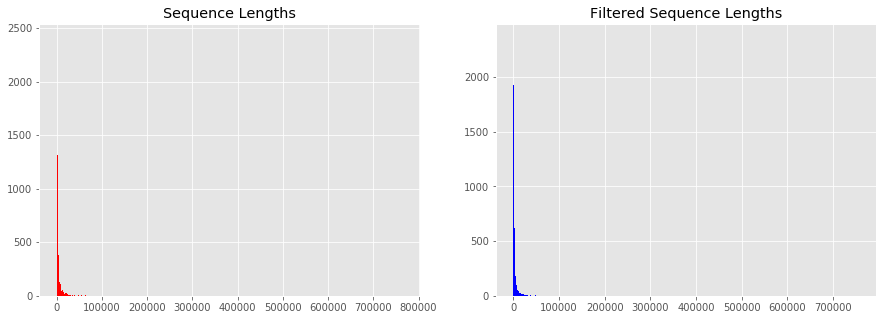

In [15]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.hist(lengths_raw, color='r', bins='auto')
ax1.set_title("Sequence Lengths")
ax2.hist(lengths, color='b', bins='auto')
ax2.set_title("Filtered Sequence Lengths")

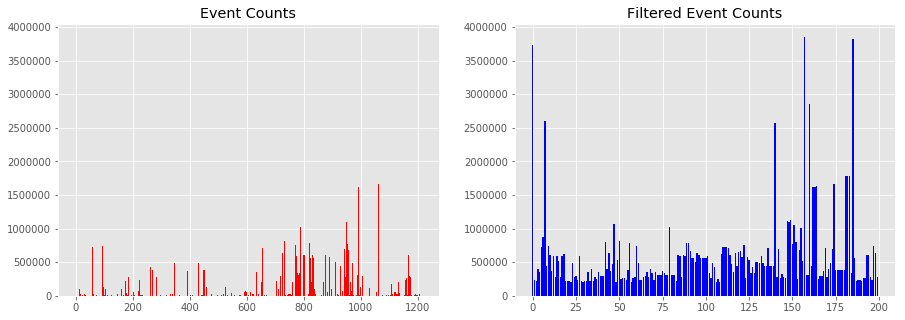

In [16]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.bar(range(len(counts_raw)), [c for i, c in counts_raw.items()], color='r')
ax2.bar(range(len(counts)), [c for i, c in counts.items()], color='b')
ax1.set_title("Event Counts")
ax2.set_title("Filtered Event Counts")

# Skip-Gram Word Embeddings

In [48]:
def to_one_hot(vocab_size):
    def f(idx):
        zeros = np.zeros(vocab_size)
        zeros[idx] = 1
        return zeros

    return f

def build_skipgrams(sequences, vocab_size, one_hot=False):
    ''' This constructs simple skip grams,
    assumes max 2 skips per word; skip window of one.
    For every word x, produce two y = neighbors(x).
    both x_train and y_train will be matricies with shape (n, d)
    where d is the size of the vocabulary and n is resultant sample size'''
    data = []
    for seq in sequences:
        for i in range(len(seq) - 1):
            data.append((seq[i], seq[i + 1]))
            data.append((seq[i + 1], seq[i]))

    if one_hot:
        vectorize = to_one_hot(vocab_size)
        x_train = []
        y_train = []

        for d in data:
            x_train.append(vectorize(d[0]))
            y_train.append(vectorize(d[1]))
        x_train = np.asarray(x_train)
        y_train = np.asarray(y_train)

    else:
        x_train = np.asarray(data)[:, 0]
        y_train = np.asarray(data)[:, 1]

    return x_train, y_train

In [ ]:
vocab_size = len(counts)
x_train, y_train = build_skipgrams(batch, vocab_size, one_hot=True)

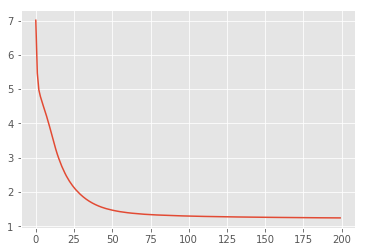

In [233]:
embedding_dim = 32

x = tf.keras.layers.Input(shape=(vocab_size,))
embedding = tf.keras.layers.Dense(embedding_dim)(x)
y_pred = tf.keras.layers.Dense(vocab_size, activation='softmax')(embedding)
model = tf.keras.models.Model(x, y_pred)
model.compile(optimizer='adam', loss='categorical_crossentropy')

hist = model.fit(x_train[:1000], y_train[:1000],
                 batch_size=64,
                 epochs=200,
                verbose=0)

plt.plot(hist.history['loss'])

In [229]:
embed = tf.keras.models.Model(x, embedding)

train_idx = range(1000)#np.random.randint(0, x_train.shape[0], 1000)
x_embed = embed.predict(x_train[train_idx])

In [230]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=250)
low_dim_embeds = tsne.fit_transform(x_embed)

In [231]:
rescaled = StandardScaler().fit_transform(x_embed)
db = DBSCAN(eps=.15, min_samples=10).fit(rescaled)
labels = db.labels_
silhouette = silhouette_score(rescaled, labels) if len(np.unique(db.labels_)) > 1 else 0.0

print("NB clusters: ", len(np.unique(labels)))
print("Silhouette Score: {}".format(silhouette))

NB clusters:  26
Silhouette Score: 0.3945351541042328


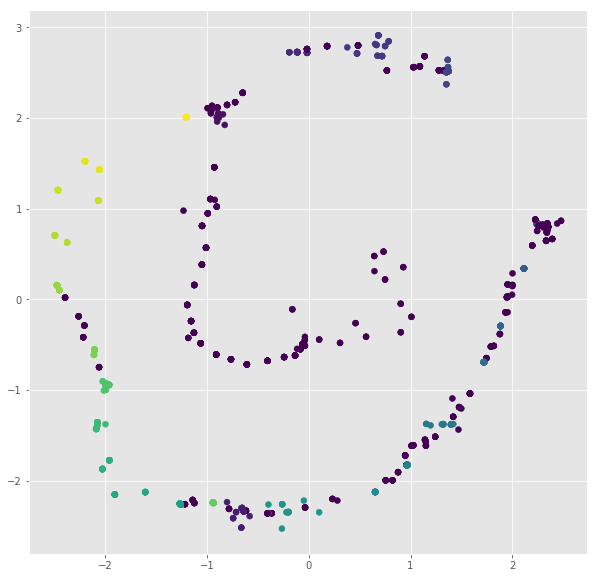

In [232]:
plt.figure(figsize=(10,10))
plt.scatter(low_dim_embeds[:,0], low_dim_embeds[:,1], c=labels)

# Seq2Seq Autoencoder Embedding

In [25]:
def to_onehot_tensor(sequences, maxlen, vocab_size):
    ''' Maps a list of N lists with arbitrary length 
    to a tensor with shape (N, maxlen, vocab_size)'''
    onehot_tensor = np.zeros((len(sequences), maxlen, vocab_size))
    
    for i, seq in enumerate(sequences):
        for j, idx in enumerate(seq):
            if j >= maxlen:
                break
            onehot_tensor[i,j,idx] = 1.0

    return onehot_tensor

In [27]:
max(lengths)

757036

In [29]:
vocab_size = len(counts)
maxlen = 1000
targetlen = 100

%time x_train = to_onehot_tensor(batch, maxlen, vocab_size).reshape(-1, targetlen, vocab_size)
print(x_train.shape)

MemoryError: 

(273440, 100, 200)


In [31]:
tf.__version__

'1.1.0'

In [30]:
embedding_dim = 32
hidden_dim = 32

x = tf.keras.layers.Input(shape=(targetlen, vocab_size))
encoder = tf.keras.layers.LSTM(embedding_dim)(x)
embedding = tf.keras.layers.RepeatVector(targetlen)(encoder)
decoder = tf.keras.layers.LSTM(hidden_dim, return_sequences=True)(embedding)
y_pred = tf.keras.layers.Dense(vocab_size, activation='softmax')(decoder)
model = tf.keras.models.Model(x, y_pred)
model.compile(optimizer='adam', loss='categorical_crossentropy')

hist = model.fit(x_train[:100], x_train[:100],
                 batch_size=64,
                 epochs=200)

plt.plot(hist.history['loss'])

AttributeError: module 'tensorflow' has no attribute 'keras'

In [104]:
embed = tf.keras.models.Model(x, encoder)

train_idx = range(1000)#np.random.randint(0, x_train.shape[0], 1000)
x_embed = embed.predict(x_train[train_idx])

In [105]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=250)
low_dim_embeds = tsne.fit_transform(x_embed)

In [106]:
rescaled = StandardScaler().fit_transform(x_embed)
db = DBSCAN(eps=.15, min_samples=10).fit(rescaled)
labels = db.labels_
silhouette = silhouette_score(rescaled, labels) if len(np.unique(db.labels_)) > 1 else 0.0

print("NB clusters: ", len(np.unique(labels)))
print("Silhouette Score: {}".format(silhouette))

NB clusters:  2
Silhouette Score: 0.15728849172592163


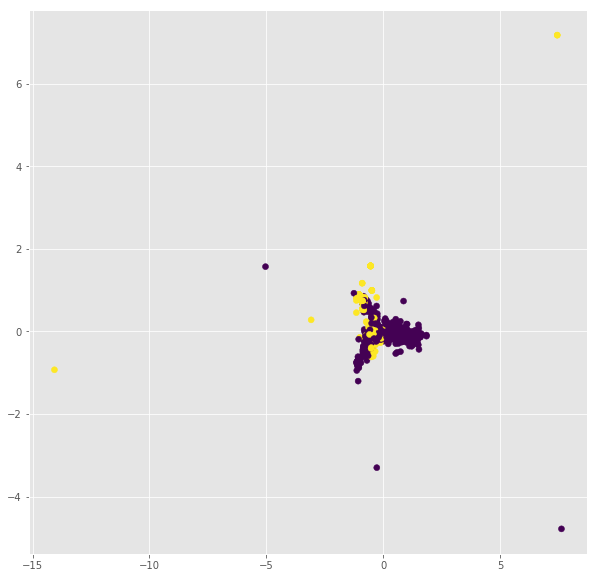

In [107]:
plt.figure(figsize=(10,10))
plt.scatter(low_dim_embeds[:,0], low_dim_embeds[:,1], c=labels)